In [121]:
using Random;
using Distributions;
using LinearAlgebra;
using JuMP;
using Roots;
using Ipopt;
using Plots;
using Dates;
using CSV;
using Optim;
using NLSolversBase;
using QuantEcon;
using CompEcon;
using DataFrames;

In [3]:
mutable struct fafchamps_struct
    delta::Float64;
    sigma::Float64;
    rho::Float64;
    gamma::Float64;
    R::Float64;
    alpha::Float64;
    r1::Float64;
    beta::Float64;
    r2::Float64;
    b::Float64;
    sigma0::Float64;
    sigma1::Float64;
    sigma2::Float64;
    mu_A::Float64;
    sigma_A::Float64;
    N::Int64;
end

function fafchamps_mod(;
        delta = 0.76839,
        sigma = 0.95534,
        rho = 0.72795,
        gamma = 0.5,
        R = 0.5,
        alpha = 0.999,
        r1 = -4.32815,
        beta = 0.46377,
        r2 = -0.05717,
        b = 2.95781,

        sigma0 = 0.86582,
        sigma1 = 1.15954,
        sigma2 = 0.62278,
        
        mu_A = -0.3,
        sigma_A = sqrt(2 * (log(0.82) - mu_A)),
        N = 1000
    )
    return param = fafchamps_struct(
        delta, sigma, rho, gamma, R, alpha,
        r1, beta, r2, b,
        sigma0, sigma1, sigma2,
        mu_A, sigma_A, N
    )
end

param = fafchamps_mod()

fafchamps_struct(0.76839, 0.95534, 0.72795, 0.5, 0.5, 0.999, -4.32815, 0.46377, -0.05717, 2.95781, 0.86582, 1.15954, 0.62278, -0.3, 0.4506640905955603, 1000)

In [6]:
A = exp.(randn(param.N) .* param.sigma_A .+ param.mu_A);
u0 = randn(param.N);
u1 = randn(param.N);
u2 = randn(param.N);

In [103]:
function Euler2_function(
        l2::Float64,
        u1::Float64,
        l1::Float64,
        u0::Float64,
        A::Float64,
        param::fafchamps_struct
    )

    # Gaussian quadrature nodes and weights for normal errors
    node, weight = qnwnorm(6);    
    
    y1 = A * exp(u0 * param.sigma0);
    y2 = (
            param.alpha * y1^param.r1 + 
            (1. - param.alpha) * l1^param.r1
        )^(1. / param.r1) * 
        exp(u1 * param.sigma1);
    y3 = param.b * (
            param.beta * y2^param.r2 + 
            (1. - param.beta) * l2^param.r2
        )^(1. / param.r2) .* 
        exp.(node .* param.sigma2);
    dy3_dl2 = param.b * (
            param.beta * y2^param.r2 + 
            (1. - param.beta) * l2^param.r2
        )^(1. / param.r2 - 1.) * 
        (1. - param.beta) * l2^(param.r2 - 1.) .* 
        exp.(node .* param.sigma2);

    output = dot(
        weight,
        (
            param.delta * (
                param.gamma * (1. - l1)^param.sigma .+ 
                (1. - param.gamma) .* (1. - l2)^param.sigma
                )^(param.rho / param.sigma) .+
            (1. - param.delta) .* y3.^param.rho
        ).^((1. - param.R) / param.rho - 1.) .* (
            - param.delta * (
                param.gamma * (1. - l1)^param.sigma + 
                (1. - param.gamma) * (1. - l2)^param.sigma
                )^(param.rho / param.sigma - 1.) * 
            (1. - param.gamma) * (1. - l2)^(param.sigma - 1.) .+ 
            (1. - param.delta) .* y3.^(param.rho - 1.) .* dy3_dl2
        )
    );
    
    return output
end;


function Euler1_function(
        l1::Float64,
        A::Float64,
        u0::Float64,
        param::fafchamps_struct
    )

    # Gaussian quadrature nodes and weights for normal errors
    node, weight = qnwnorm(6);    
    l2_node = zeros(6);
    
    for (u1_node, i) in zip(node, 1:6)
        l2_node[i] = find_zero(
            x -> Euler2_function(x, u1_node, l1, u0, A, param), 
            (1e-14, 1.0 - 1e-14)
        )
    end
    
    node_2, weight_2 = qnwnorm([6, 6], 0., 1.);
    u1 = node_2[:, 1];
    u2 = node_2[:, 2];
    l2_node_ext = repeat(l2_node, 6);
    
    y1 = A * exp(u0 * param.sigma0);
    y2 = (
            param.alpha * y1^param.r1 + 
            (1. - param.alpha) * l1^param.r1
        )^(1. / param.r1) .* 
        exp.(u1 .* param.sigma1)
    y3 = param.b .* (
            param.beta .* y2.^param.r2 .+ 
            (1. - param.beta) .* l2_node_ext.^param.r2
        ).^(1. / param.r2) .* 
        exp.(u2 .* param.sigma2);
    dy3_dy2 = param.b .* (
            param.beta .* y2.^param.r2 .+ 
            (1. - param.beta) .* l2_node_ext.^param.r2
        ).^(1. / param.r2 - 1.) .*
        param.beta .* y2.^(param.r2 - 1.) .* exp.(u2 .* param.sigma2);
    dy2_dl1 = (
            param.alpha .* y1.^param.r1 .+ 
            (1. - param.alpha) .* l1.^param.r1
        ).^(1. / param.r1 - 1.) .*
        (1. - param.alpha) .* l1.^(param.r1 - 1.) .* 
        exp.(u1 .* param.sigma1);

    output = dot(
        weight_2,
        (
            param.delta * (
                param.gamma * (1. - l1)^param.sigma .+ 
                (1. - param.gamma) .* (1. .- l2_node_ext).^param.sigma
                ).^(param.rho / param.sigma) .+
            (1. - param.delta) .* y3.^param.rho
        ).^((1. - param.R) / param.rho - 1.) .* (
            - param.delta * (
                param.gamma * (1. - l1)^param.sigma .+ 
                (1. - param.gamma) * (1. .- l2_node_ext).^param.sigma
                ).^(param.rho / param.sigma - 1.) .* 
            param.gamma * (1. - l1)^(param.sigma - 1) .+ 
            (1. - param.delta) .* y3.^(param.rho - 1.) .* dy3_dy2 .* dy2_dl1
        )
    )
    
    return output
end;




In [105]:
@time Euler1_function(0.1, 0.1, 0.1, param)

  0.001230 seconds (3.39 k allocations: 376.047 KiB)


-0.4234543328104428

In [106]:
function simulate_l1_l2(
    A::Float64,
    u0::Float64,
    u1::Float64,
    param::fafchamps_struct)
    
    l1 = find_zero(
            x -> Euler1_function(x, A, u0, param), 
            (1e-14, 1.0 - 1e-14)
        );
    l2 = find_zero(
            x -> Euler2_function(x, u1, l1, u0, A, param), 
            (1e-14, 1.0 - 1e-14)
        );
    
    return (l1, l2)
end
    

simulate_l1_l2 (generic function with 1 method)

In [154]:
@time simulate_l1_l2(0.1, 0.1, 0.1, param)

  0.180662 seconds (224.94 k allocations: 24.337 MiB, 64.89% gc time)


(0.031773195132608845, 0.1872510061145687)

In [110]:
@time begin
l1_sim = zeros(param.N);
l2_sim = zeros(param.N);
for i in 1:param.N
    l1_sim[i], l2_sim[i] = simulate_l1_l2(A[i], u0[i], u1[i], param)
end
end

 67.725550 seconds (223.73 M allocations: 23.637 GiB, 8.21% gc time)


In [120]:
y1 = A .* exp.(u0 * param.sigma0);
y2 = (
    param.alpha .* y1.^param.r1 .+ 
    (1. - param.alpha) .* l1_sim.^param.r1
    ).^(1. / param.r1) .* exp.(u1 .* param.sigma1);
y3 = param.b .* (
    param.beta .* y2.^param.r2 .+ 
    (1. - param.beta) .* l2_sim.^param.r2
    ).^(1. / param.r2) .* exp.(u2 .* param.sigma2);


In [124]:
df = DataFrame(
    A = A,
    y1 = y1,
    y2 = y2,
    y3 = y3
);
first(df, 10)

,A,y1,y2,y3
,Float64,Float64,Float64,Float64
1,1.15705,0.375389,0.106783,0.279733
2,1.17217,3.84699,2.34136,3.12452
3,0.910833,1.99078,1.211,2.58037
4,0.653335,0.911989,0.186095,0.578669
5,0.957223,0.296958,0.351373,2.02199
6,1.18717,1.35026,3.80986,5.71502
7,0.686221,1.22353,0.507806,1.99084
8,0.264021,0.355115,0.212473,0.943813
9,0.864113,0.348203,0.270974,2.8906


In [133]:
theta0_grid = -4:.1:4;
l1_fig1 = zeros((length(theta0_grid), 4));

for (i, A_fig1) in enumerate([0.5, 1, 2, 4])
    for (j, theta0_fig1) in enumerate(theta0_grid)
        l1_fig1[j, i] = find_zero(
            x -> Euler1_function(
                x, A_fig1, theta0_fig1 / param.sigma0, param
                ), 
            (1e-14, 1.0 - 1e-14)    
        )
    end
end

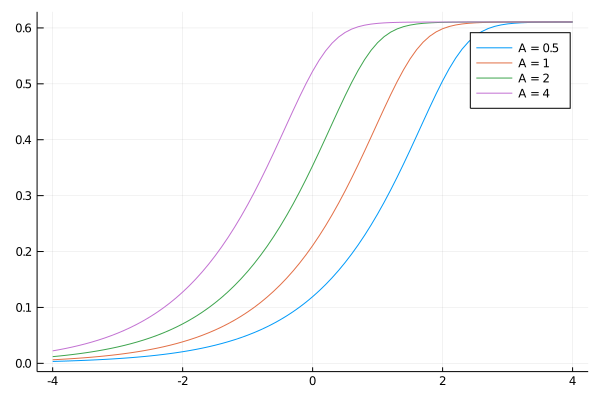

In [138]:
plot(
    theta0_grid, l1_fig1,
    label = ["A = 0.5" "A = 1" "A = 2" "A = 4"]
)

In [140]:
theta1_grid = -3:0.1:3;
A_fig2 = 1.;
l2_fig2 = zeros((length(theta1_grid), 4));

for (i, theta0_fig2) in enumerate([-2, -1, 1, 2])
    l1_fig2 = find_zero(
        x -> Euler1_function(
            x, A_fig2, theta0_fig2 / param.sigma0, param
            ), 
        (1e-14, 1.0 - 1e-14)    
    )
    for (j, theta1_fig2) in enumerate(theta1_grid)
        l2_fig2[j, i] = find_zero(
            x -> Euler2_function(
                x, theta1_fig2 / param.sigma1, l1_fig2,
                theta0_fig2 / param.sigma0, A_fig2, param
                ), 
            (1e-14, 1.0 - 1e-14)    
        )
    end
end

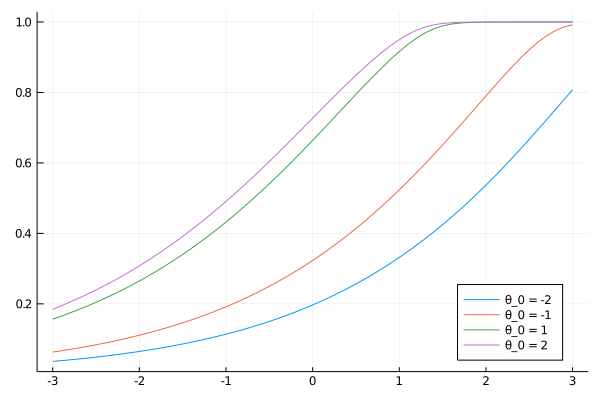

In [153]:
plot(
    theta1_grid, l2_fig2,
    label = ["θ_0 = -2" "θ_0 = -1" "θ_0 = 1" "θ_0 = 2"],
    legend = (0.85, 0.2)
)

In [158]:
function find_theta2(
    y3::Float64,
    u0::Float64,
    u1::Float64,
    A::Float64,
    l1::Float64,
    l2::Float64,
    param::fafchamps_struct)
    
    y1 = A * exp(u0 * param.sigma0);
    y2 = (
        param.alpha * y1^param.r1 + 
        (1. - param.alpha) * l1^param.r1
        )^(1. / param.r1) * exp(u1 * param.sigma1);
    theta2 = log(
        y3 / (param.b * (
                param.beta * y2^param.r2 + 
                (1. - param.beta) * l2^param.r2
            )^(1. / param.r2)
        )
    )
    
    return theta2
end

function find_theta(
        l1::Float64,
        l2::Float64,
        y3::Float64, 
        A::Float64, 
        param::fafchamps_struct)

    u0 = find_zero(
       x -> Euler1_function(
            l1, A, x, param
            ), (-5., 5.)
    );
    u1 = find_zero(
       x -> Euler2_function(
            l2, x, l1, u0, A, param
            ), (-5., 5.)
    );
            
    theta0 = u0 * param.sigma0;
    theta1 = u1 * param.sigma1;
    theta2 = find_theta2(y3, u0, u1, A, l1, l2, param);
    return (theta0, theta1, theta2)
end

find_theta (generic function with 1 method)

In [163]:
theta0_model = zeros(param.N);
theta1_model = zeros(param.N);
theta2_model = zeros(param.N);

@time begin
for i in 1:param.N
    theta0_model[i], theta1_model[i], theta2_model[2] = find_theta(
        l1_sim[i], l2_sim[i], y3[i], A[i], param
    )
end
end

 62.166295 seconds (245.39 M allocations: 25.926 GiB, 5.36% gc time)


In [168]:
l1_model = zeros(param.N);
l2_model = zeros(param.N);

@time begin
for i in 1:param.N
        l1_model[i], l2_model[i] = simulate_l1_l2(
            A[i], 
            theta0_model[i] / param.sigma0, 
            theta1_model[i] / param.sigma1, 
            param
        )
end
end

 56.361657 seconds (223.52 M allocations: 23.614 GiB, 5.27% gc time)


In [198]:
param_temp = fafchamps_struct(
    param.delta * 1.0, param.sigma, 
    param.rho, param.gamma, param.R, param.alpha,
    param.r1 * 0.99, param.beta, param.r2, param.b,
    param.sigma0, param.sigma1, param.sigma2,
    param.mu_A, param.sigma_A, param.N
    )

fafchamps_struct(0.76839, 0.95534, 0.72795, 0.5, 0.5, 0.999, -4.2848685, 0.46377, -0.05717, 2.95781, 0.86582, 1.15954, 0.62278, -0.3, 0.4506640905955603, 1000)

In [199]:
theta0_model = zeros(param.N);
theta1_model = zeros(param.N);
theta2_model = zeros(param.N);

@time begin
for i in 1:param.N
    theta0_model[i], theta1_model[i], theta2_model[2] = find_theta(
        l1_sim[i], l2_sim[i], y3[i], A[i], param_temp
    )
end
end

 60.908417 seconds (245.39 M allocations: 25.926 GiB, 5.28% gc time)
